In [1]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from pymoo.util.dominator import Dominator
from pymoo.indicators.hv import Hypervolume
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C , WhiteKernel
from pymoo.operators.sampling.lhs import LHS
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.display.output import Output, pareto_front_if_possible
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np
import random

#### Number of Bojectives = 2 , Number of decision variables = 2 , Number of samples = 20(10 x 2)

In [2]:
weight_vectors = get_reference_directions('energy',2,20)

In [3]:
problem = DTLZ2(n_obj=2,n_var=2)
sampling  = LHS()
ref_dirs = sampling(problem,20).get('X')

In [4]:
ref_dirs

array([[0.82326262, 0.46309051],
       [0.17747844, 0.36709998],
       [0.11380632, 0.61847968],
       [0.75493001, 0.02823934],
       [0.69246995, 0.94070048],
       [0.42625392, 0.86681981],
       [0.00119456, 0.42119199],
       [0.20252519, 0.71016849],
       [0.86073848, 0.28219421],
       [0.33226597, 0.80828975],
       [0.35291128, 0.59525811],
       [0.46988066, 0.66802846],
       [0.91699191, 0.95955811],
       [0.57224616, 0.33434769],
       [0.95456291, 0.19296154],
       [0.62506521, 0.08408172],
       [0.70943668, 0.79351378],
       [0.05550854, 0.23774379],
       [0.26305307, 0.51065996],
       [0.53406428, 0.1228341 ]])

In [5]:
output = {}
problem._evaluate(ref_dirs,output)

In [6]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,3):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2']


In [7]:
dataset.head()

,x1,x2,Objective 1,Objective 2
0,0.823263,0.463091,0.274439,0.963021
1,0.177478,0.367100,0.978372,0.280046
2,0.113806,0.618480,0.997877,0.180312
3,0.754930,0.028239,0.459092,1.133086
4,0.692470,0.940700,0.554711,1.057568


##### MOdelling on Objective 1

In [8]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [9]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Model on Objective 2

In [10]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [11]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [12]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [13]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm,
                ('n_gen', 50),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm,
                ('n_gen', 50),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [14]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [15]:
def optimize_problem(algorithm, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = np.array([max(dataset['Objective 1']),max(dataset['Objective 2'])])
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm))
        new_data = list(ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    plt.plot(list(range(1,52)),Hypervolume)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return new_dataset


In [16]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm = NSGA2(pop_size = 100)
algorithm_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3 = NSGA3(ref_dirs=weight_vectors)


Iteration 0 initial Hypervolume is 0.3945410288012182
Iteration : 1 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 2 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 3 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 4 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 5 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 6 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 7 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 8 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 9 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 10 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 11 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 12 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 13 Hypervolume of Non Dominated Front is 0.3954953672829721
Iteration : 14 Hype

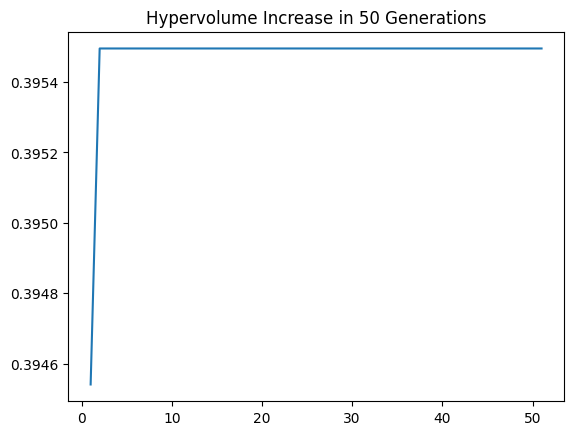

70

In [17]:
new_dataset = optimize_problem(algorithm,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.3945410288012182
Iteration : 1 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 2 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 3 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 4 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 5 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 6 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 7 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 8 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 9 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 10 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 11 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 12 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 13 Hypervolume of Non Dominated Front is 0.3995531909656924
Iteration : 14 Hype

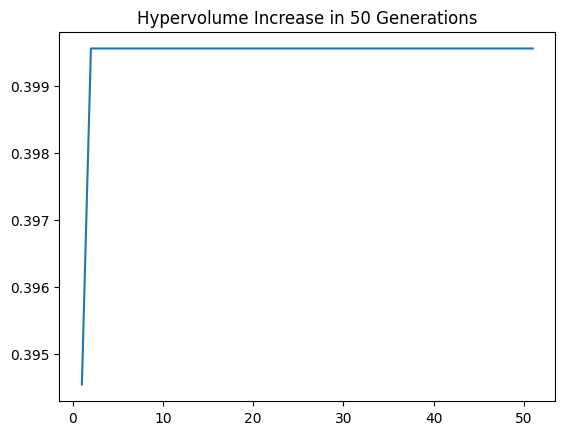

70

In [19]:
new_dataset = optimize_problem(algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.3945410288012182
Iteration : 1 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 2 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 3 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 4 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 5 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 6 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 7 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 8 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 9 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 10 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 11 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 12 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 13 Hypervolume of Non Dominated Front is 0.3945410288012182
Iteration : 14 Hype

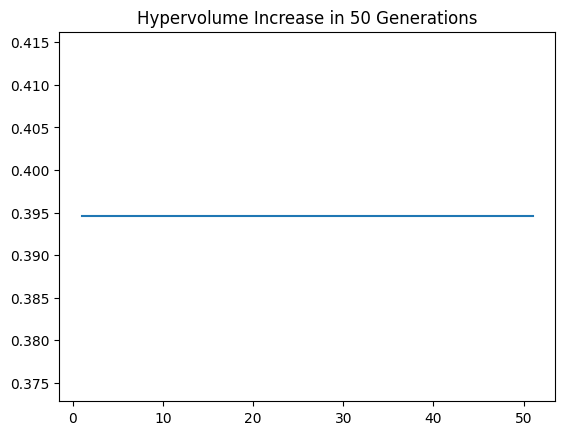

70

In [20]:
new_dataset = optimize_problem(algorithm_3,problem_1,problem_2)
len(new_dataset)
